## Data Augmentation With CNN

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import seaborn as sns
device='cuda' if torch.cuda.is_available() else 'cpu'
fmnist=datasets.FashionMNIST(r'../data',download=True,train=True)
val_fmnist=datasets.FashionMNIST(r'../data',download=True,train=False)
tr_images,tr_targets=fmnist.data,fmnist.targets
val_images,val_targets=fmnist.data,val_fmnist.targets
aug=iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)},mode='constant')
])

In [2]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()
class FMNISTDataset(Dataset):
    def __init__(self,x,y,aug=None):
        self.x,self.y=x,y
        self.aug=aug
    def __getitem__(self, item):
        return self.x[item],self.y[item]
    def __len__(self):
        return len(self.x)
    def collate_fn(self,batch):
        """
        logic to modify a batch of images
        :param batch: 
        :return: 
        """
        ims,classes=list(zip(*batch))
        ims=[im.tolist() for im in ims]
        ims=torch.tensor(ims,dtype=torch.uint8)
        # transform a batch of images at once
        if self.aug:
            ims=self.aug.augment_images(images=to_numpy(ims[:len(ims)]))
        ims=torch.tensor(ims).view(len(ims),-1,28,28).to(device)/255
        classes=torch.tensor(classes).to(device)
        return ims,classes

def get_model():
    model=nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200,256),
        nn.ReLU(),
        nn.Linear(256,10)
    ).to(device)
    loss_fn=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    batch_loss=loss_fn(model(x),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def get_data():
    train=FMNISTDataset(tr_images,tr_targets,aug=aug)
    'notice the collate_fn argument'
    trn_dl=DataLoader(train,batch_size=64,collate_fn=train.collate_fn,shuffle=True)
    val=FMNISTDataset(val_images,val_targets)
    val_dl=DataLoader(val,batch_size=len(val_images),collate_fn=val.collate_fn,shuffle=False)
    return trn_dl,val_dl

In [3]:
trn_dl,val_dl=get_data()
model,loss_fn,optimizer=get_model()
for epoch in range(5):
    print(epoch)
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        batch_loss=train_batch(x,y,model,optimizer,loss_fn)
        batch_loss=train_batch(x,y,model,optimizer,loss_fn)

0
1
2
3
4


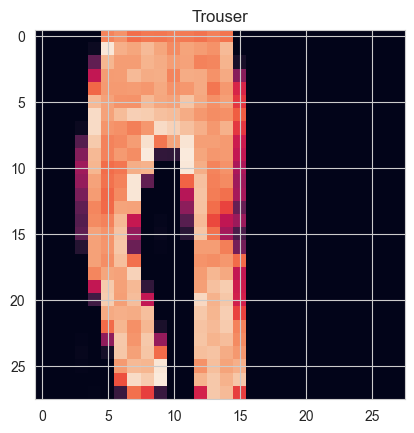

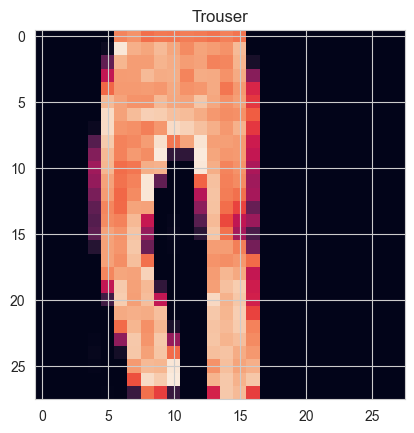

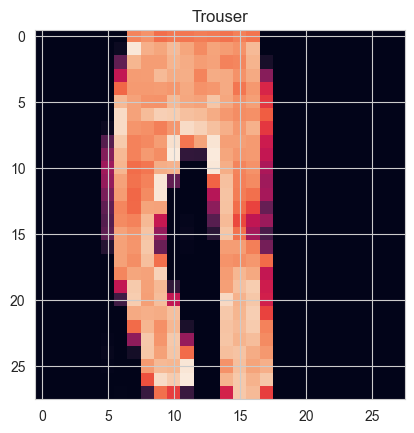

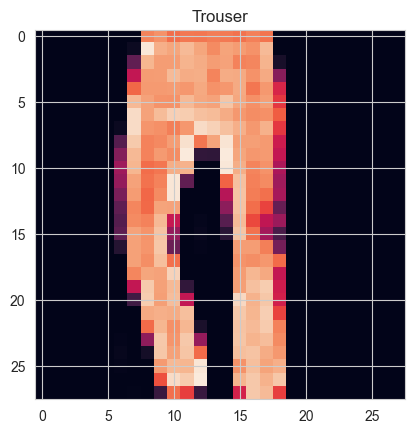

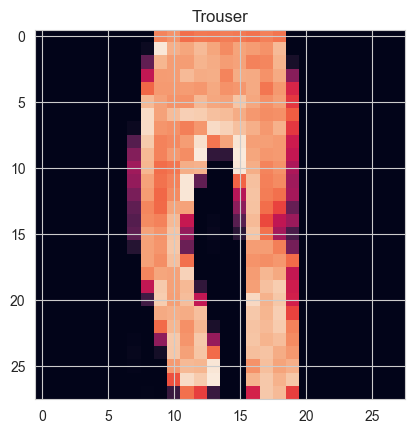

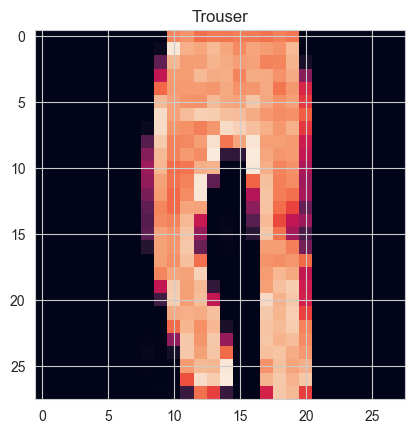

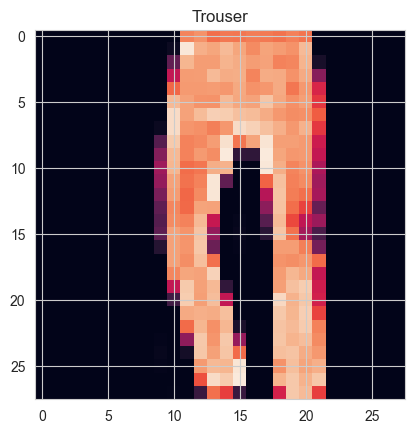

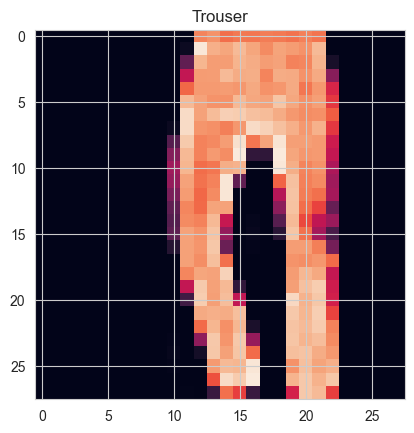

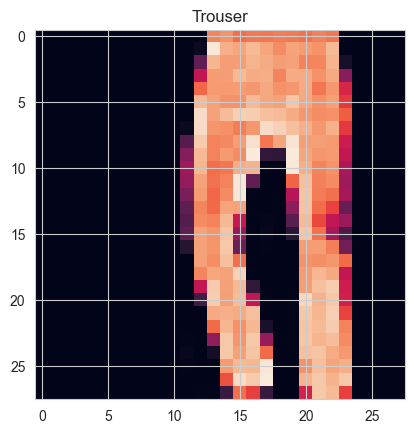

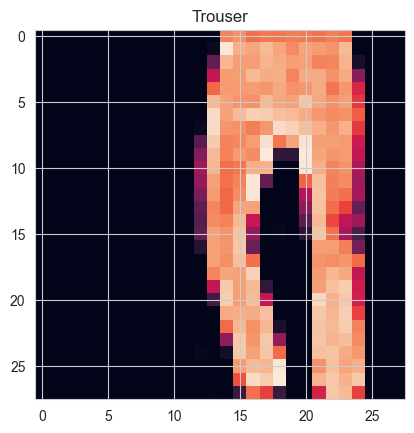

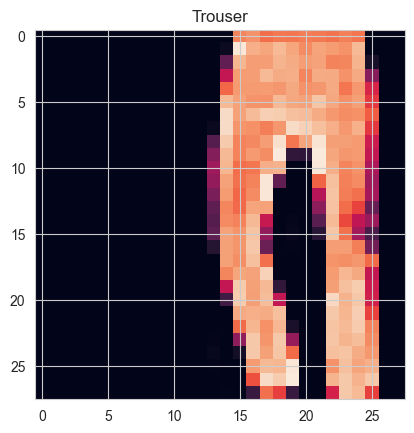

In [4]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

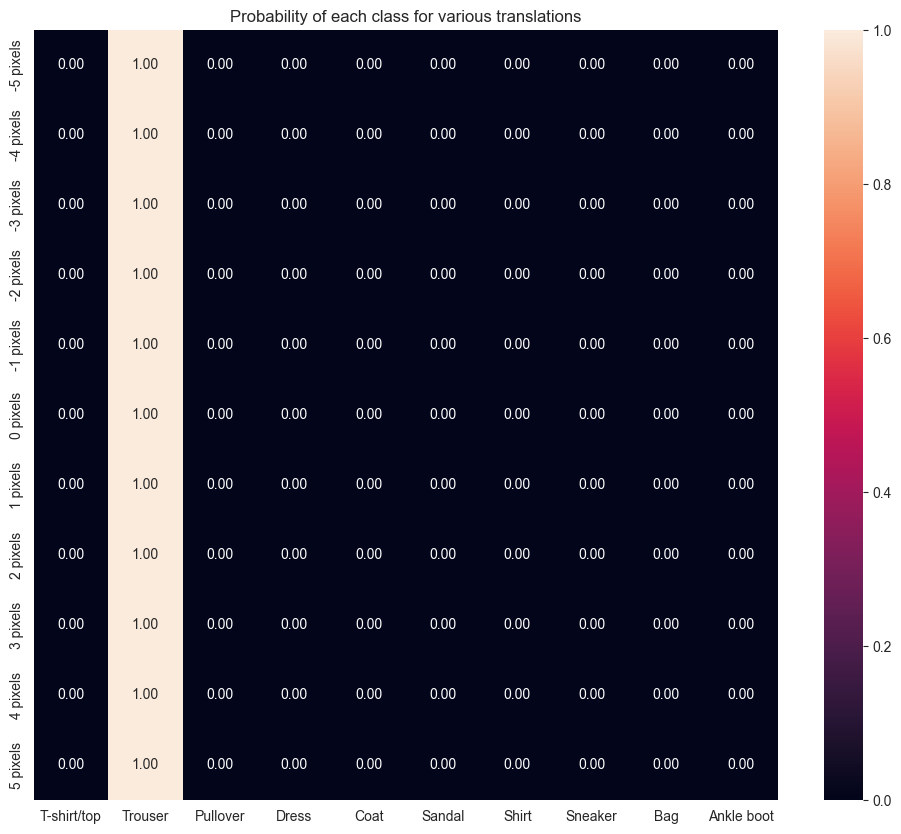

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)])